In [12]:
# pip install pygbif

In [13]:
import os # Interoperable file paths
from glob import glob
import pathlib 
import requests

# Data Tools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from math import floor, ceil

# Spatial tools
import earthaccess
import geopandas as gpd
import rioxarray as rxr
import rioxarray.merge as rxrm
import xarray as xr
import xrspatial

# GBIF packages
import pygbif.occurrences as occ
import pygbif.species as species
from getpass import getpass
import time
import zipfile

# Visualizing Tools
import holoviews as hv
import hvplot.pandas
import hvplot.xarray


In [14]:
%run scripts.py

In [15]:
# Define and create the project data directory
data_dir = os.path.join(
    # Home
    pathlib.Path.home(),
    # Earth Analytics
    'earth-analytics',
    'data',
    'habitat-suitability'
)
os.makedirs(data_dir, exist_ok=True)

# Habitat suitability of American Ginseng (*Panax quinquefolius*) under climate change

## STEP 1: STUDY OVERVIEW

### American Ginseng (*Panax quinquefolius*)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/Panax_quinquefolius.jpg/960px-Panax_quinquefolius.jpg?20060208013541" alt="Panax quinquefolius - US FWS photo" style="width:600px;"/>

American ginseng is a perennial herb native to eastern forests of the United States, from Maine to Alabama and west to Michigan, Wisconsin and Minnesota [(Harrison et al.)](https://corn.aae.wisc.edu/Crops/Ginseng.aspx). The plant grows to two feet in height, has palmately compound leaves made up of five serrated leaflets arranged in a single whorl. It blooms as one greenish-white flower umbel per stem that turn to bright red drupes in the fall.

The root of American Ginseng is where its value to humans lies. Indiginous Americans had a variety of uses for the root; from herbal remedies to good luck charms. In the modern day, it has a high demand in the United States and China as an herbal remedy [(Anderson & Peterson, 2003)](https://plants.usda.gov/DocumentLibrary/plantguide/pdf/cs_paqu.pdf). Overharvesting lead to the plant being listed in Appendix II of the [Convention on International Trade in Endangered Species (CITES)](https://cites.org/eng/app/appendices.php) in the 1970s. Because a permit is not required to export artificially propagated ginseng, agricultural researchers have looked to determine the conditions necessary for growth of the plant.

American ginseng grows best in climates with an average of 50 degrees Fahrenheit and between 40 to 50 in. of annual precipitation. It preferes well-drained, loamy soils at least 12 in. deep with a pH near 5.5 [(Harrison et al.)](https://corn.aae.wisc.edu/Crops/Ginseng.aspx). Ginseng favors north or east facing slopes that are not too steep to maintain deep topsoil [(Vaughan et al., 2011)](https://www.fs.usda.gov/nac/assets/documents/research/publications/2011ginsengforest.pdf).

As climate conditions continue to change globally, the distribution of this plant may change as well. To gain insight into these changes, this analysis examines how American Ginseng will respond to different climate conditions for the rest of the century.

In [16]:
reset_credentials = False

# GBIF credentials
credentials = dict(
    GBIF_USER=(input, 'GBIF username:'),
    GBIF_PWD=(getpass, 'GBIF password:'),
    GBIF_EMAIL=(input, 'GBIF email:')
)
for env_variable, (prompt_func, prompt_text) in credentials.items():
    # Delete credential from environment if requested
    if reset_credentials and (env_variable in os.environ):
        os.environ.pop(env_variable)
    # Ask for credential and save to environment
    if not env_variable in os.environ:
        os.environ[env_variable] = prompt_func(prompt_text)

In [17]:
# Species Information
species_name = 'Panax quinquefolius'
species_info = species.name_lookup(species_name, rank='species')
species_result = species_info['results'][0]
species_key = species_result['nubKey']

species_result['species'], species_key

('Panax quinquefolius', 5372246)

In [18]:
# GBIF species directory
gbif_dir = os.path.join(data_dir,
                        'GBIF',
                        species_result['species'])

# GBIF file path
gbif_pattern = os.path.join(gbif_dir, '*.csv')

# Only download once
if not glob(gbif_pattern):
    gbif_query = occ.download([
        f'speciesKey = {species_key}',
        'hasCoordinate = True'
    ])
    download_key = gbif_query[0]

    if not 'GBIF_DOWNLOAD_KEY' in os.environ:
        os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]
    

    # Wait for download to build
    wait = occ.download_meta(download_key)['status']
    while not wait=='SUCCEEDED':
        wait = occ.download_meta(download_key)['status']
        time.sleep(5)
    
    # Download GBIF data
    download_info = occ.download_get(
        os.environ['GBIF_DOWNLOAD_KEY'],
        path=gbif_dir)

    # Unzip
    with zipfile.ZipFile(download_info['path']) as download_zip:
        download_zip.extractall(path=gbif_dir)
    
# Extracted .csv file path
gbif_path = glob(gbif_pattern)[0]


In [19]:
# Open GBIF csv as DataFrame
gbif_df = pd.read_csv(
    gbif_path,
    delimiter = '\t'
)
gbif_df.columns

Index(['gbifID', 'datasetKey', 'occurrenceID', 'kingdom', 'phylum', 'class',
       'order', 'family', 'genus', 'species', 'infraspecificEpithet',
       'taxonRank', 'scientificName', 'verbatimScientificName',
       'verbatimScientificNameAuthorship', 'countryCode', 'locality',
       'stateProvince', 'occurrenceStatus', 'individualCount',
       'publishingOrgKey', 'decimalLatitude', 'decimalLongitude',
       'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation',
       'elevationAccuracy', 'depth', 'depthAccuracy', 'eventDate', 'day',
       'month', 'year', 'taxonKey', 'speciesKey', 'basisOfRecord',
       'institutionCode', 'collectionCode', 'catalogNumber', 'recordNumber',
       'identifiedBy', 'dateIdentified', 'license', 'rightsHolder',
       'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted',
       'mediaType', 'issue'],
      dtype='object')

In [20]:
gbif_gdf = (
    gpd.GeoDataFrame(
        gbif_df,
        geometry=gpd.points_from_xy(
            gbif_df.decimalLongitude,
            gbif_df.decimalLatitude
        ),
        crs='EPSG:4326'
    ))

In [21]:
# Plot
gbif_gdf.hvplot(
    geo=True, tiles='EsriImagery',
    title = 'American Ginseng occurrences in GBIF',
    fill_color = None, line_color = 'white',
    frame_width = 600
)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]

Occurrences of American Ginseng (*Panax quinquefolius*) are mainly found in the Eastern Forests of the United States and southern Canada. Other dispersed occurrences are found in botanical collections throughout the world. This occurrence data is aggregated  by the Global Biodiversity Information Facility (GBIF).

Data Citation: 
  GBIF.org (8 March 2025) GBIF Occurrence Download https://doi.org/10.15468/dl.yheype 

### Sites

National Forests will be the focus for ginseng habitat, since they are likely to have the heavy canopy coverage that the plant requires to grow. We will overlay the occurrence data from GBIF onto National Forest boundaries and choose two sites based on the number of American ginseng occurrences recorded.

In [22]:
# Create site boundary data directory in the project folder
boundary_dir = os.path.join(data_dir, 'USFS')
os.makedirs(boundary_dir, exist_ok=True)

# Define info for USFS National Forests download
boundary_url = ("https://data-usfs.hub.arcgis.com/"
                "api/download/v1/items/3451bcca1dbc45168ed0b3f54c6098d3"
                "/shapefile?layers=0")
boundary_path = os.path.join(boundary_dir, 'USFS_boundary.shp')

# Only download once
if not os.path.exists(boundary_path):
    boundary_gdf = gpd.read_file(boundary_url)
    boundary_gdf.to_file(boundary_path)

# Load from file
else:
    boundary_gdf = gpd.read_file(boundary_path)


USFS National Forest administrative boundaries were obtained from the FS National Forests Dataset (US Forest Service Proclaimed Forests) Dataset.

Citation: U.S. Forest Service. (2 November 2024). FS National Forests Dataset (US Forest Service Proclaimed Forests). [Accessed 8 March 2025] URL: https://catalog.data.gov/dataset/fs-national-forests-dataset-us-forest-service-proclaimed-forests-2c16c

In [23]:
Panax_FS = gpd.overlay(gbif_gdf, boundary_gdf, how='intersection')


C:\Users\tjsto\AppData\Local\Temp\ipykernel_15624\3274261762.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  Panax_FS = gpd.overlay(gbif_gdf, boundary_gdf, how='intersection')


In [24]:
value_counts = Panax_FS['FORESTNAME'].value_counts()
value_counts

FORESTNAME
Shawnee National Forest                42
Nantahala National Forest              41
Pisgah National Forest                 28
Wayne National Forest                  20
Monongahela National Forest            18
Daniel Boone National Forest           18
Ozark National Forest                  11
Chattahoochee National Forest          11
Ouachita National Forest               10
Green Mountain National Forest          9
George Washington National Forest       9
Cherokee National Forest                9
Hoosier National Forest                 8
Jefferson National Forest               8
William B. Bankhead National Forest     5
Mark Twain National Forest              5
Sumter National Forest                  3
Tombigbee National Forest               1
Ottawa National Forest                  1
Allegheny National Forest               1
White Mountain National Forest          1
Chequamegon National Forest             1
Name: count, dtype: int64

Because the American Ginseng is a species of concern recovering from overharvest, sites with higher occurrences may show significant changes based on future climate conditions. Shawnee National Forest and Nantahala National Forest have the highest recorded occurrences of American Ginseng, we will focus our analysis there.

In [25]:
# Select boundaries for the forests of interest
shawnee_gdf = boundary_gdf[boundary_gdf['FORESTNAME'] == 'Shawnee National Forest']
nantahala_gdf = boundary_gdf[boundary_gdf['FORESTNAME'] == 'Nantahala National Forest']

# Site list to loop through
site_list = [shawnee_gdf, nantahala_gdf]

# Concatenate GDFs to loop through later on
sites_gdf = gpd.GeoDataFrame(
    pd.concat([shawnee_gdf, nantahala_gdf], ignore_index=True))

sites_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    2 non-null      int32   
 1   PROCLAIMED  2 non-null      object  
 2   FORESTNAME  2 non-null      object  
 3   GIS_ACRES   2 non-null      float64 
 4   SHAPEAREA   2 non-null      float64 
 5   SHAPELEN    2 non-null      float64 
 6   geometry    2 non-null      geometry
dtypes: float64(3), geometry(1), int32(1), object(2)
memory usage: 236.0+ bytes


In [26]:
# Plot boundary line of a gdf
def plot_site(gdf):
    gdf_plot = (
        gdf.dissolve().hvplot(
            geo=True, tiles='EsriImagery',
            title=gdf.FORESTNAME.values[0],
            fill_color=None, line_color='white', line_width=3,
            frame_width=600
        )
    )
    return gdf_plot

In [27]:
# Plot first site using script.py function
plot_site(shawnee_gdf)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

[Shawnee National Forest](https://www.fs.usda.gov/shawnee) is nestled in southern Illinois between the Ohio and Mississippi rivers. It spans 289,000 acres featuring oak-hickory forests, wetlands, grasslands, and unique geological features. As Shawnee Forest is located close to the western extent of American Ginseng range, it may provide insight into changes in moisture levels affecting its distribution.

In [28]:
# Second site
plot_site(nantahala_gdf)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

[Nantahala National Forest](https://www.fs.usda.gov/recarea/nfsnc/recarea/?recid=48634) encompasses 531,000 acres of mountain and valleys in southwestern North Carolina. The elevation ranges from 1,200 feet along the Hiwassee River to 5,800 feet at Lone Bald. Near the southern extent of American Ginseng's range, Nantahala National Forest may indicate how the plant will respond to warming temperatures.

### Time periods

In general when studying climate, we are interested in **climate
normals**, which are typically calculated from 30 years of data so that
they reflect the climate as a whole and not a single year which may be
anomalous. We will examine a mid-century period from 2036 to 2065 and a 
late-century period from 2066 to 2095.

### Climate models

-   Warm and wet HadGEM2-CC365
-   Warm and dry CanESM2
-   Cold and wet MIROC5
-   Cold and dry MRI-CGCM3

Hegewisch, K.C. and Abatzoglou, J.T..' Future Climate Scatter' web tool. Climate Toolbox (https://climatetoolbox.org/) accessed on 8 March 2025.

## STEP 2: DATA ACCESS

### Soil data

The [POLARIS dataset](http://hydrology.cee.duke.edu/POLARIS/) is a
convenient way to uniformly access a variety of soil parameters such as
pH and percent clay in the US. It is available for a range of depths (in
cm) and split into 1x1 degree tiles.


In [29]:
def download_tif(url, save_path):
    """Function to download and save .tif files"""
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        print(f"Downloaded: {save_path}")
    else: 
        print(f"Failed to download {url}. Status code: {response.status_code}")

In [30]:
def polaris_soil_data(variable, statistic, depth, gdf, save_folder):
    """
    Function to download soil data from the Polaris Dataset.
    ---
    Parameters:
    variable : str
        The soil characteristic being examined.
    statistic : str
        Aggregate method used to summarize soil data.
    depth : str
        Soil depth that the variable is measured at.
    gdf : GeoDataFrame
        Boundary that data will be focused on.
    save_folder : str
        Name of directory that .tif files will be saved to within data directory
    ---
    Returns:
    A collection of .tif files for the selected parameters focused on the 
    boundary.

    """
    # Ensure the save directory exists
    polaris_dir = os.path.join(data_dir, 'polaris/'+save_folder)
    os.makedirs(polaris_dir, exist_ok=True)

    # Create list of soil data URLs
    soil_url_template = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0"
                "/{variable}"
                "/{statistic}"
                "/{depth}"
                "/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif")

    bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
        gdf.total_bounds)

    soil_url_list = []

    for lesser_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):
        for lesser_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
            soil_url = soil_url_template.format(
                variable=variable,
                statistic=statistic,
                depth=depth,
                min_lat=lesser_lat, max_lat=lesser_lat+1, 
                min_lon=lesser_lon, max_lon=lesser_lon+1)
            soil_url_list.append(soil_url)

    # Download the files locally
    for url in soil_url_list:
        # Extract file name from url
        split_url = url.split("/")[-5:]
        filename = ''
        for i in split_url:
            filename+=i

        # Download the .tif file once
        save_path = os.path.join(polaris_dir, filename)
        if not os.path.exists(save_path):
            download_tif(url, save_path)

In [31]:
def set_buffer(boundary_gdf, buffer=0):
    """
    Increases the max bounds of a geo data frame by a set amount.
    Returns the max bounds as a tuple.
    """
    bounds = tuple(boundary_gdf.total_bounds)
    xmin, ymin, xmax, ymax = bounds
    bounds_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)

    return bounds_buffer

In [32]:
def process_image(file_pattern, boundary_gdf, buffer=0):
    """Load image, crop to study boundary, merge assays"""
    
    # Set a buffer to crop images to
    bounds_buffer = set_buffer(boundary_gdf, buffer)
    
    # Open and crop the images
    da_list = []
    for file_path in glob(file_pattern):
        tile_da = (
            rxr.open_rasterio(file_path, mask_and_scale=True)
            .squeeze())
        cropped_da = tile_da.rio.clip_box(*bounds_buffer)
        da_list.append(cropped_da)
    
    # Merge the list of cropped data arrays
    merged_da = rxrm.merge_arrays(da_list)
    
    # Returns a cropped and merged data array
    return merged_da

In [33]:
soil_ph_das = []

for site in site_list:
    site_soil_data = polaris_soil_data(
        'ph', 'p50', '15_30', site, site.FORESTNAME.values[0])
    site_soil_path = os.path.join(
        data_dir,
        'polaris',
        site.FORESTNAME.values[0],
        '*.tif')
    site_ph_da = process_image(site_soil_path, site)
    soil_ph_das.append(dict(
        site_name=site.FORESTNAME.values[0],
        soil_variable='ph',
        soil_da=site_ph_da))

soil_df = pd.DataFrame(soil_ph_das)
soil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   site_name      2 non-null      object
 1   soil_variable  2 non-null      object
 2   soil_da        2 non-null      object
dtypes: object(3)
memory usage: 180.0+ bytes


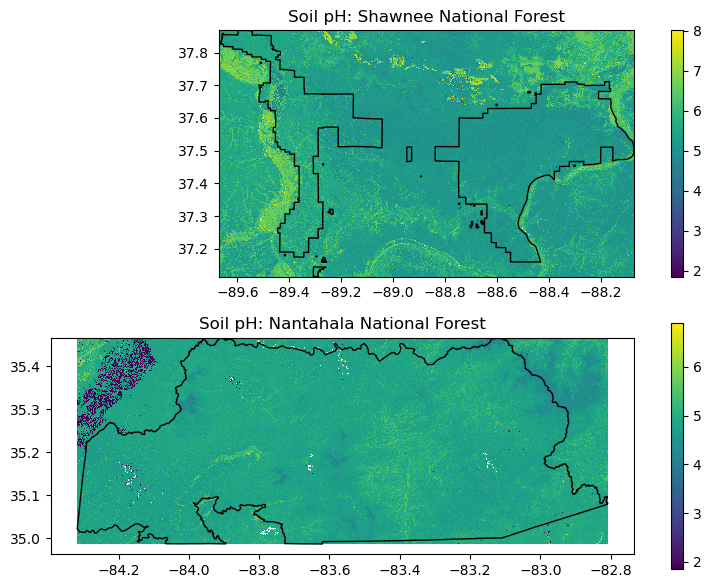

In [34]:
# Visualize the soil data

num_plots = len(soil_df.soil_da)

# Create subplots dynamically based on the number of plots
fig, axes = plt.subplots(num_plots, 1, figsize=(8, 6))

# In case of only one plot
if num_plots == 1:
    axes = [axes]

# Loop over soil DataArrays and site list
for i, (site_ph_da, site) in enumerate(zip(soil_df.soil_da, site_list)):

    # Display raster data
    im = axes[i].imshow(
        site_ph_da.values, 
        cmap='viridis', 
        interpolation='nearest', 
        extent=(
            site_ph_da.x.min(),
            site_ph_da.x.max(),
            site_ph_da.y.min(),
            site_ph_da.y.max()
        ))
    # Set title based on site name
    axes[i].set_title(f"Soil pH: {site.FORESTNAME.values[0]}")
    # Set site boundary line
    site.boundary.plot(ax=axes[i], color='black', linewidth=1)
    # Set colorbar
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

### Topographic data

Elevation data accessed from the [SRTM
dataset](https://www.earthdata.nasa.gov/data/instruments/srtm),
available through the [earthaccess
API](https://earthaccess.readthedocs.io/en/latest/quick-start/).

In [35]:
# Download elevation data
def srtm_data_download(boundary_gdf, buffer=0.025):
    elevation_dir = os.path.join(data_dir, 
                                  'srtm',
                                  boundary_gdf.FORESTNAME.values[0])
    os.makedirs(elevation_dir, exist_ok=True)

    srtm_pattern = os.path.join(elevation_dir, '*.hgt.zip')

    bounds_buffer = set_buffer(boundary_gdf, buffer)

    if not glob(srtm_pattern):
        srtm_results = earthaccess.search_data(
            short_name='SRTMGL1',
            bounding_box=bounds_buffer
        )
        srtm_results = earthaccess.download(srtm_results, elevation_dir)
    
    srtm_da_list = []

    for srtm_path in glob(srtm_pattern):
        tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
        cropped_da = tile_da.rio.clip_box(*bounds_buffer)
        srtm_da_list.append(cropped_da)
    
    srtm_da =rxrm.merge_arrays(srtm_da_list)

    return srtm_da

In [36]:
def derive_slope(site_gdf, elevation_da):
    # Estimate the UTM CRS based on the bounds of the site
    epsg_utm = site_gdf.estimate_utm_crs()
    # Reproject boundary and elevation data so that units are in meters
    elevation_proj_da = elevation_da.rio.reproject(epsg_utm)
    site_proj_gdf = site_gdf.to_crs(epsg_utm)
    
    # Calculate slope using xrspatial
    slope_full_da = xrspatial.slope(elevation_proj_da)
    slope_da = slope_full_da.rio.clip(site_proj_gdf.geometry)

    return slope_da

In [37]:
def derive_aspect(site_gdf, elevation_da):
    # Estimate the UTM CRS based on the bounds of the site
    epsg_utm = site_gdf.estimate_utm_crs()
    # Reproject boundary and elevation data so that units are in meters
    elevation_proj_da = elevation_da.rio.reproject(epsg_utm)
    site_proj_gdf = site_gdf.to_crs(epsg_utm)
    
    # Calculate slope using xrspatial
    aspect_full_da = xrspatial.aspect(elevation_proj_da)
    aspect_da = aspect_full_da.rio.clip(site_proj_gdf.geometry)

    return aspect_da

In [38]:
elevation_das = []

for site in site_list:
    elevation_da = srtm_data_download(site)
    elevation_das.append(dict(
        site_name=site.FORESTNAME.values[0],
        elevation_da=elevation_da
    ))
topo_df = pd.DataFrame(elevation_das)

In [39]:
slope_das = []

for (site, elevation_da) in zip(site_list, topo_df.elevation_da):
    slope_da = derive_slope(site, elevation_da)
    slope_da = slope_da.rio.reproject_match(elevation_da)
    slope_das.append(slope_da)

topo_df['slope_da'] = slope_das

In [40]:
aspect_das = []

for (site, elevation_da) in zip(site_list, topo_df.elevation_da):
    aspect_da = derive_aspect(site, elevation_da)
    aspect_da = aspect_da.rio.reproject_match(elevation_da)
    aspect_das.append(aspect_da)

topo_df['aspect_da'] = aspect_das
    

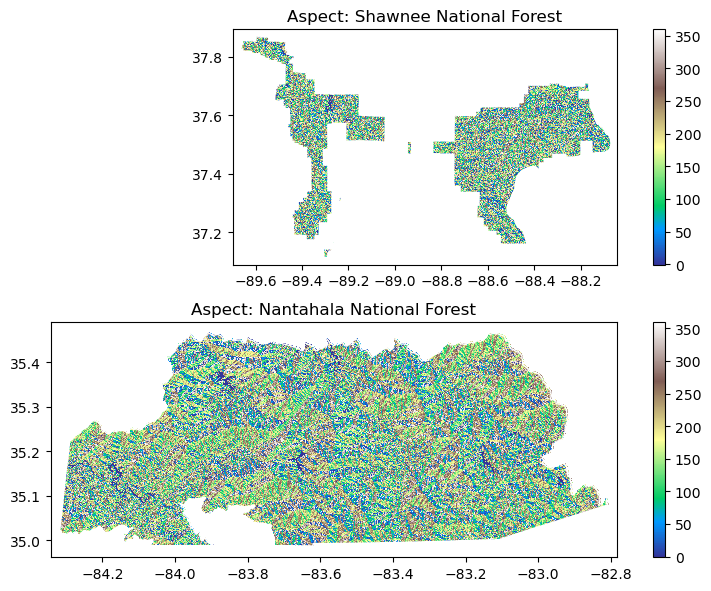

In [43]:
# Visualize the elevation data

num_plots = len(topo_df.aspect_da)

# Create subplots dynamically based on the number of plots
fig, axes = plt.subplots(num_plots, 1, figsize=(8, 6))

# In case of only one plot
if num_plots == 1:
    axes = [axes]

# Loop over soil DataArrays and site list
for i, (site_da, site) in enumerate(zip(topo_df.aspect_da, site_list)):

    # Display raster data
    im = axes[i].imshow(
        site_da.values, 
        cmap='terrain', 
        interpolation='nearest', 
        extent=(
            site_da.x.min(),
            site_da.x.max(),
            site_da.y.min(),
            site_da.y.max()
        ))
    # Set title based on site name
    axes[i].set_title(f"Aspect: {site.FORESTNAME.values[0]}")
    # Set site boundary line
    site.boundary.plot(ax=axes[i], color='white', linewidth=1)
    # Set colorbar
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

### Climate model data

<a
href="http://thredds.northwestknowledge.net:8080/thredds/reacch_climate_CMIP5_macav2_catalog2.html">MACAv2
dataset, accessible from Northwest Knowledge Network's Thredds server</a>. 

In [44]:
def convert_longitude(longitude):
    """Convert longitude range from 0-360 to [-180:180]"""
    return (longitude - 360) if longitude > 180 else longitude

In [45]:
# Download climate data
def MACAv2_data(variable, model, scenario, start_year, site_gdf):
    """
    Downloads climate raster data from the MACAv2 dataset.
    ------------------------------------------------------
    variable : str
      The climate variable to serve as the raster values.
    model : str
      The climate model to gather data from.
    scenario : str
      The emissions scenario e.g. rcp45.
    start_year : int
      Start of 5-year period for data on XXX1 or XXX6.
    site_gdf : GeoDataFrame
      Geospatial area that climate data is requested for.
    -------------------------------------------------------
    Returns
    maca_da : rio.xarray.DataArray
      A data array with raster data for the parameters of choice.
    """
    end_year = 2099 if start_year == 2096 else (start_year + 4)
    maca_url = (
        'http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2'
        f'/{model}/macav2metdata_{variable}_{model}_r1i1p1_'
        f'{scenario}_{start_year}_{end_year}_CONUS_monthly.nc')
    maca_da = xr.open_dataset(maca_url).squeeze().precipitation
    bounds = site_gdf.to_crs(maca_da.rio.crs).total_bounds
    # Reassign coordinates to [-180:180]
    maca_da = maca_da.assign_coords(
        lon=("lon", [convert_longitude(l) for l in maca_da.lon.values])
    )
    maca_da = maca_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
    maca_da = maca_da.rio.clip_box(*bounds)


    return maca_da


In [46]:
# Define climate variables to loop through
variable_list = ['pr']
model_list = ['CanESM2', 'HadGEM2-CC365', 'MIROC5', 'MRI-CGCM3']
scenario_list = ['rcp85']
start_year_list = [2036, 2066]

maca_da_list = []
# Loop through all variables
for site in site_list:
    for variable in variable_list:
        for model in model_list:
            for scenario in scenario_list:
                for start_year in start_year_list:
                    year_list = list(
                        # Download 30-year period from start year
                        range(start_year, start_year+30, 5))
                    for year in year_list:
                        # Execute download and processing
                        maca_da = MACAv2_data(
                            variable, model, scenario, start_year, site)

                        # Structure dictionary with metadata
                        maca_da_list.append(dict(
                            site_name=site.FORESTNAME.values[0],
                            climate_model=model,
                            climate_variable=variable,
                            climate_scenario=scenario,
                            start_year=year,
                            climate_da=maca_da))

# Convert the DataArray list to a pandas DataFrame
MACAv2_df = pd.DataFrame(maca_da_list)


In [47]:
def compute_mean_of_group(group):
    # Stack the DataArrays in the group along a new dimension
    stacked_data = xr.concat(group, dim='concat_dim')
    # Return the mean along the 'concat_dim' axis
    return stacked_data.mean(dim='concat_dim')

In [48]:
# Split df by 30 year climate period
MACA_group_1 = MACAv2_df[MACAv2_df['start_year'] <= 2061]
MACA_group_2 = MACAv2_df[MACAv2_df['start_year'] > 2061]

# Group by sites, model, etc.
MACA_group_A = MACA_group_1.groupby(
    ['site_name', 'climate_model', 'climate_variable','climate_scenario'],
    as_index=False)['climate_da'].apply(compute_mean_of_group)
MACA_group_B = MACA_group_2.groupby(
    ['site_name', 'climate_model', 'climate_variable','climate_scenario'],
    as_index=False)['climate_da'].apply(compute_mean_of_group)

In [49]:
MACA_grouped_df = pd.concat([MACA_group_A, MACA_group_B],
                            ignore_index=True)

MACA_grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   site_name         16 non-null     object
 1   climate_model     16 non-null     object
 2   climate_variable  16 non-null     object
 3   climate_scenario  16 non-null     object
 4   climate_da        16 non-null     object
dtypes: object(5)
memory usage: 772.0+ bytes


## STEP 3: HARMONIZE DATA

In [50]:
maca_da_repr_list = []

for row in range(len(MACA_grouped_df)):
    maca_da_orig = (
        MACA_grouped_df.iloc[row]['climate_da']
        .rio.write_crs(4326, inplace=False)
        .rio.set_spatial_dims('lat', 'lon')
        .groupby('time.year')
        .sum()
        .min('year')
    )
    maca_da_repr = maca_da_orig.rio.reproject_match(
        topo_df[topo_df['site_name'] == MACA_grouped_df.iloc[row]['site_name']]
        .elevation_da.item())
    maca_da_repr_list.append(maca_da_repr)

MACA_grouped_df['climate_da'] = maca_da_repr_list

In [51]:
soil_da_repr_list = []

for i in range(len(soil_df)):

    soil_da_orig = (
        soil_df.iloc[i]['soil_da'])
    soil_da_repr = soil_da_orig.rio.reproject_match(
        topo_df[topo_df['site_name'] == soil_df.iloc[i]['site_name']]
        .elevation_da.item())
    soil_da_repr_list.append(soil_da_repr)

soil_df['soil_da'] = soil_da_repr_list

In [52]:
aspect_da_repr_list = []

for i in range(len(topo_df)):

    aspect_da_orig = (
        topo_df.iloc[i]['aspect_da'])
    aspect_da_repr = aspect_da_orig.rio.reproject_match(
        topo_df.iloc[i].elevation_da)
    aspect_da_repr_list.append(aspect_da_repr)

topo_df['aspect_da'] = aspect_da_repr_list

In [53]:
# List of DataFrames to loop through
dfs = [soil_df, topo_df, MACA_grouped_df]

forest_df = dfs[0]

for merging_df in dfs[1:]:
    # Join DataFrames
    forest_df = pd.merge(forest_df, merging_df, on='site_name')

forest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   site_name         16 non-null     object
 1   soil_variable     16 non-null     object
 2   soil_da           16 non-null     object
 3   elevation_da      16 non-null     object
 4   slope_da          16 non-null     object
 5   aspect_da         16 non-null     object
 6   climate_model     16 non-null     object
 7   climate_variable  16 non-null     object
 8   climate_scenario  16 non-null     object
 9   climate_da        16 non-null     object
dtypes: object(10)
memory usage: 1.4+ KB


## STEP 4: DEVELOP A FUZZY LOGIC MODEL

In [54]:
def calculate_suitability_score(raster, optimal_value, tolerance_range):
    """
    Calculate a fuzzy suitability score (0-1) for each raster cell based on proximity to the optimal value.

    Args:
        raster (xarray.DataArray): Input raster layer.
        optimal_value (float): The optimal value for the variable.
        tolerance_range (float): The range within which values are considered suitable.

    Returns:
        xarray.DataArray: A raster of suitability scores (0-1).
    """
    # Calculate suitability scores using a fuzzy Gaussian function
    suitability = np.exp(-((raster - optimal_value) ** 2) / (2 * tolerance_range ** 2))
    return suitability


In [55]:
def build_habitat_suitability_model(input_rasters, optimal_values, tolerance_ranges,):
    """
    Build a habitat suitability model by combining fuzzy suitability scores for each variable.

    Args:
        input_rasters (list): List of paths to input raster files representing environmental variables.
        optimal_values (list): List of optimal values for each variable.
        tolerance_ranges (list): List of tolerance ranges for each variable.

    Returns:
        xarray.Datarray: A raster of combined suitability scores (0-1)
    """

    # Load and calculate suitability scores for each raster
    suitability_layers = []
    for raster, optimal_value, tolerance_range in zip(
        input_rasters, optimal_values, tolerance_ranges):
        suitability_layer = calculate_suitability_score(raster, optimal_value, tolerance_range)
        suitability_layers.append(suitability_layer)

    # Combine suitability scores by multiplying across all layers
    combined_suitability = suitability_layers[0]
    for layer in suitability_layers[1:]:
        combined_suitability *= layer

    return combined_suitability

In [56]:
optimal_values = [5.5, 45, 1143]
tolerance_ranges = [0.5, 180, 127]

In [ ]:
# Create fuzzy logic suitability model
model_list = []

for i in range(len(forest_df)):
    rasters = [
        forest_df['soil_da'][i],
        forest_df['aspect_da'][i],
        forest_df['climate_da'][i]
    ]
    model = build_habitat_suitability_model(
        rasters,
        optimal_values,
        tolerance_ranges
    )
    model_list.append(model)

## STEP 5: SHAWNEE RESULTS

At Shawnee National Forest, American Ginseng maximizes its suitable habitat under a cool and dry climate. It is possible that too much precipitation will cause the valuable roots to have fungal problems, reducing their habitat. This is especially apparent at the end of the century, when the suitable habitat for ginseng almost disappears under all but the cool and dry climate scenario.

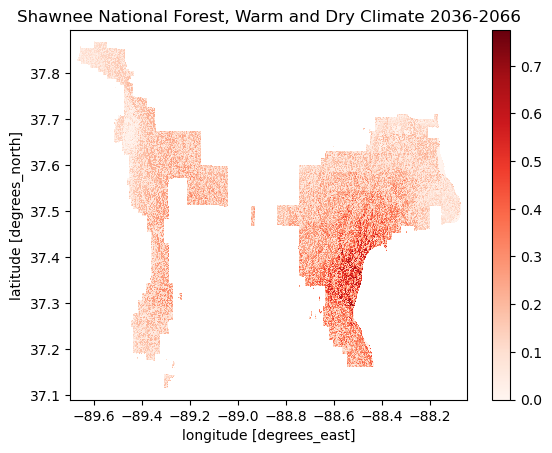

In [ ]:
model_list[0].plot(cmap='Reds')
plt.title('Shawnee National Forest, Warm and Dry Climate 2036-2066')
plt.show()

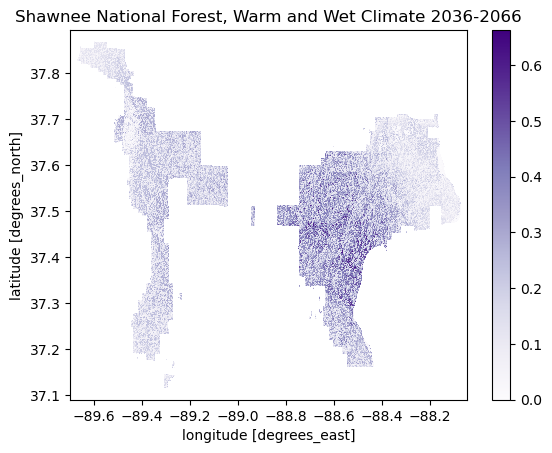

In [ ]:
model_list[1].plot(cmap='Purples')
plt.title('Shawnee National Forest, Warm and Wet Climate 2036-2066')
plt.show()

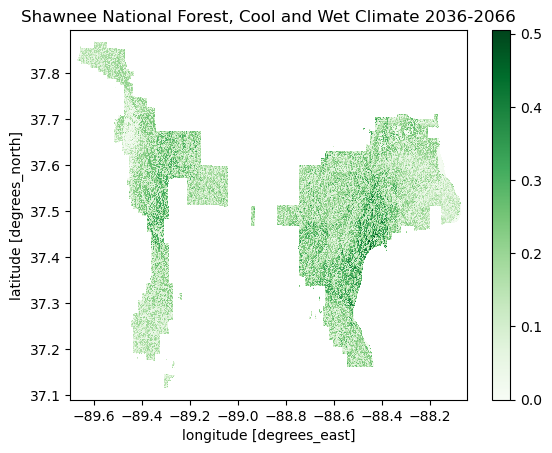

In [ ]:
model_list[2].plot(cmap='Greens')
plt.title('Shawnee National Forest, Cool and Wet Climate 2036-2066')
plt.show()

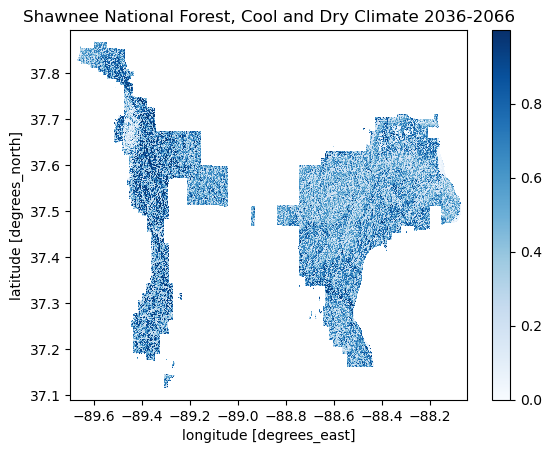

In [ ]:
model_list[3].plot(cmap='Blues')
plt.title('Shawnee National Forest, Cool and Dry Climate 2036-2066')
plt.show()

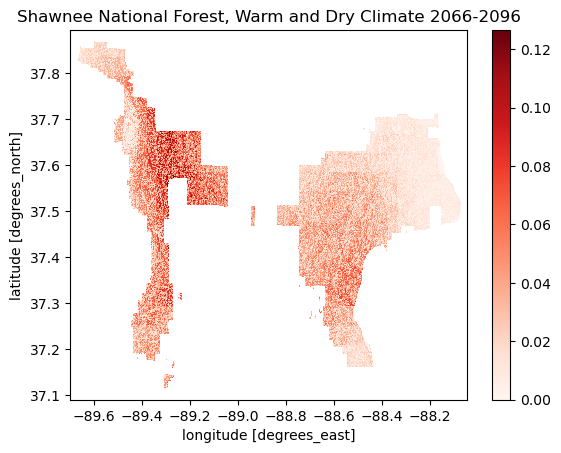

In [ ]:
model_list[4].plot(cmap='Reds')
plt.title('Shawnee National Forest, Warm and Dry Climate 2066-2096')
plt.show()

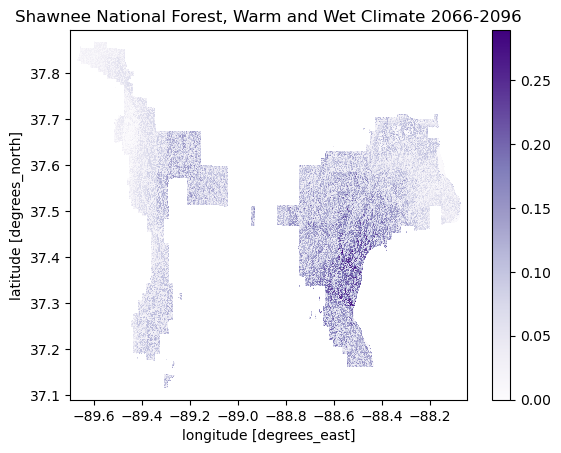

In [ ]:
model_list[5].plot(cmap='Purples')
plt.title('Shawnee National Forest, Warm and Wet Climate 2066-2096')
plt.show()

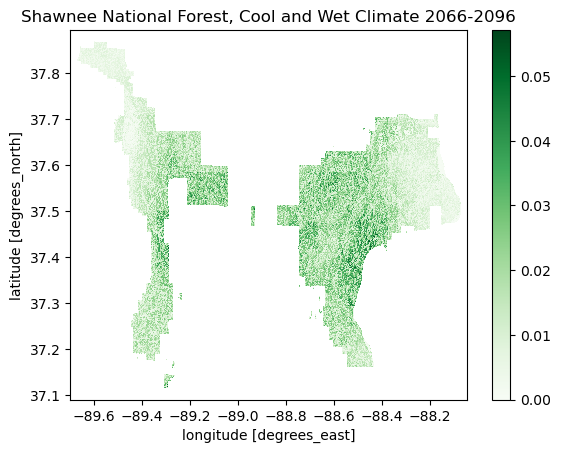

In [ ]:
model_list[6].plot(cmap='Greens')
plt.title('Shawnee National Forest, Cool and Wet Climate 2066-2096')
plt.show()

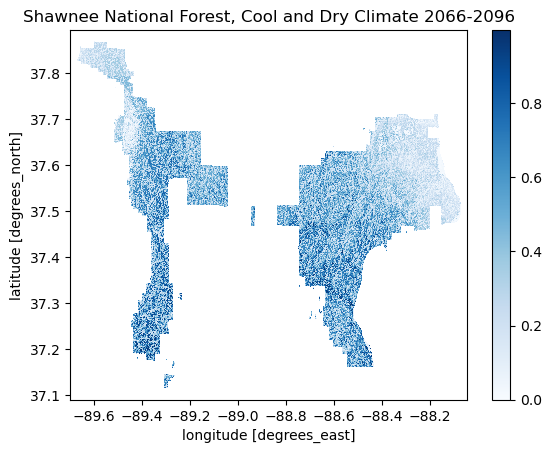

In [ ]:
model_list[7].plot(cmap='Blues')
plt.title('Shawnee National Forest, Cool and Dry Climate 2066-2096')
plt.show()

## STEP 6: NANTAHALA RESULTS

Nantahala National Forest tells us a different story, where during the mid-century, American Ginseng does best under warm and dry climate conditions. However, at the end of the century, American ginseng's habitat is most suitable at high elevations under a warm and dry climate scenario, and low elevations under a cool and wet climate scenario.

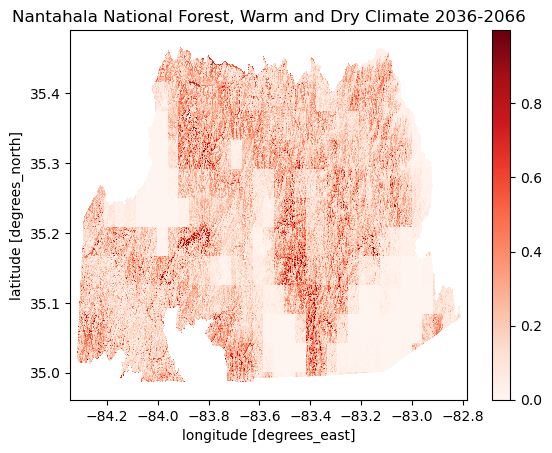

In [ ]:
model_list[8].plot(cmap='Reds')
plt.title('Nantahala National Forest, Warm and Dry Climate 2036-2066')
plt.show()

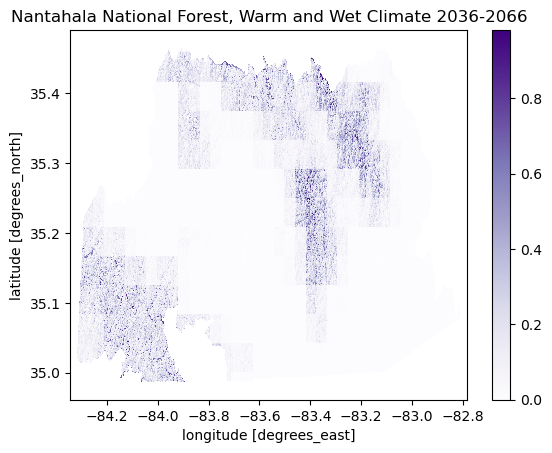

In [ ]:
model_list[9].plot(cmap='Purples')
plt.title('Nantahala National Forest, Warm and Wet Climate 2036-2066')
plt.show()

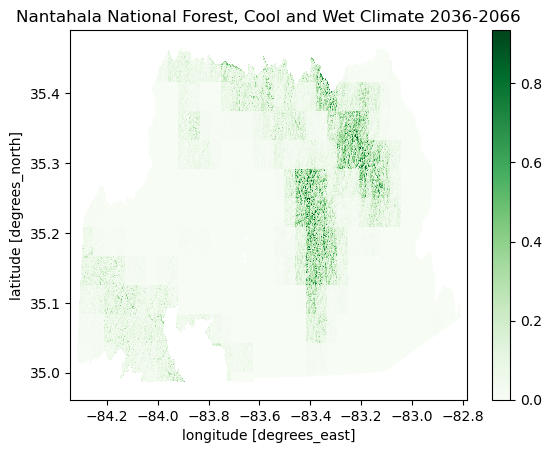

In [ ]:
model_list[10].plot(cmap='Greens')
plt.title('Nantahala National Forest, Cool and Wet Climate 2036-2066')
plt.show()

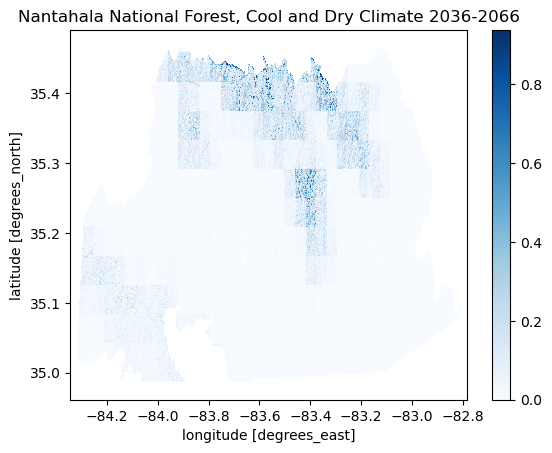

In [ ]:
model_list[11].plot(cmap='Blues')
plt.title('Nantahala National Forest, Cool and Dry Climate 2036-2066')
plt.show()

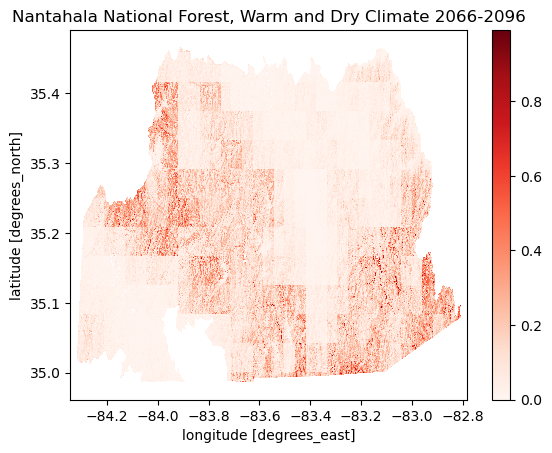

In [ ]:
model_list[12].plot(cmap='Reds')
plt.title('Nantahala National Forest, Warm and Dry Climate 2066-2096')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

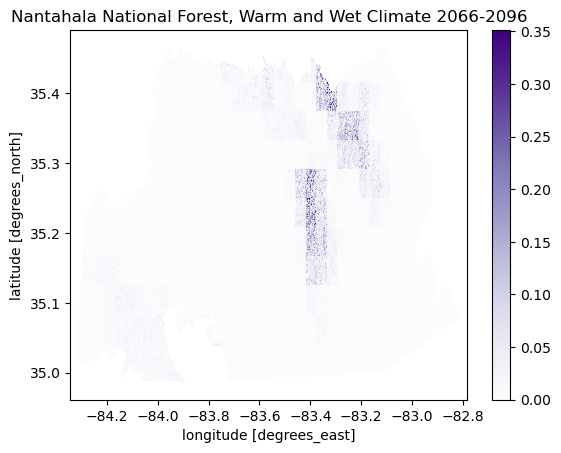

In [ ]:
model_list[13].plot(cmap='Purples')
plt.title('Nantahala National Forest, Warm and Wet Climate 2066-2096')
plt.show

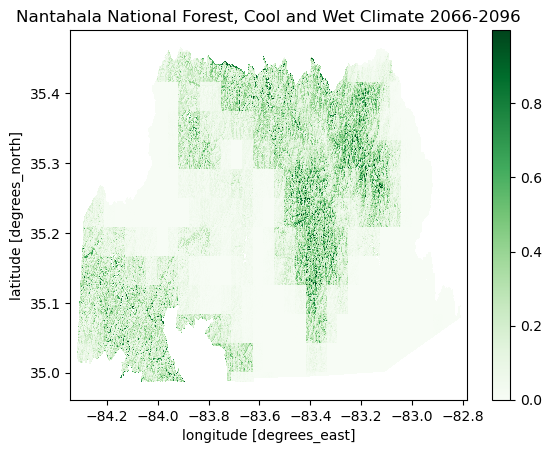

In [ ]:
model_list[14].plot(cmap='Greens')
plt.title('Nantahala National Forest, Cool and Wet Climate 2066-2096')
plt.show()

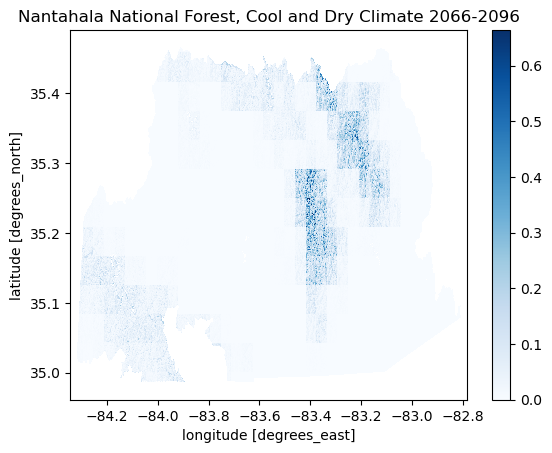

In [ ]:
model_list[15].plot(cmap='Blues')
plt.title('Nantahala National Forest, Cool and Dry Climate 2066-2096')
plt.show()